In [265]:
import numpy as np
import matplotlib.pyplot as plt
from pyTMD.time import convert_calendar_dates, datetime_to_list
from pyTMD.io import model, GOT, ATLAS
from pyTMD.predict import time_series, infer_minor, map
from datetime import datetime, timedelta

In [266]:
# Create model object
def get_tide_model(model_name, model_directory, model_format, compressed=False):
    return model(model_directory, format=model_format, compressed=compressed).elevation(model_name)

# Load and interpolate tidal constants
def get_tide_constants(lon, lat, tide_model, model_name):
    if 'GOT' in model_name:
        constituents = GOT.read_constants(tide_model.model_file, compressed=tide_model.compressed)
        amp, ph = GOT.interpolate_constants(np.array([lon]), np.array([lat]),  
                        constituents, scale=tide_model.scale, 
                        method='spline', extrapolate=True)

    elif 'atlas' in model_name:
        constituents = ATLAS.read_constants(tide_model.grid_file, tide_model.model_file, type=tide_model.type, compressed=tide_model.compressed)
        amp, ph, D = ATLAS.interpolate_constants(
                        np.atleast_1d(lon), np.atleast_1d(lat),
                        constituents, type=tide_model.type, scale=tide_model.scale,
                        method='spline', extrapolate=True)

    return constituents, amp, ph

In [267]:
# Model parameters
tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5'
tpxo9_atlas_v5 = get_tide_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)

In [7]:
print(tpxo9_atlas_v5.grid_file)

/home/bioer/python/tide/data_src/TPXO9_atlas_v5/grid_tpxo9_atlas_30_v5.nc


In [268]:
#read_netcdf_grid in ATLAS.py
import netCDF4
fileID = netCDF4.Dataset(tpxo9_atlas_v5.grid_file, 'r')
# read latitude and longitude at z-nodes
lonz = fileID.variables['lon_z'][:].copy()
latz = fileID.variables['lat_z'][:].copy()
print(lonz)
print(latz)
print(lonz.shape)
print(latz.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)

[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
(10800,)
(5401,)
5401 10800


In [269]:
bathy_z = np.ma.zeros((ny,nx))
bathy_z.data[:,:] = fileID.variables['hz'][:,:].T
bathy_z.mask = (bathy_z.data == 0.0)


In [270]:
import pathlib
import uuid
import gzip

# https://github.com/tsutterley/pyTMD/blob/main/pyTMD/io/ATLAS.py
def extend_array(input_array: np.ndarray, step_size: float):
    """
    Extends a longitude array

    Parameters
    ----------
    input_array: np.ndarray
        array to extend
    step_size: float
        step size between elements of array

    Returns
    -------
    temp: np.ndarray
        extended array
    """
    n = len(input_array)
    temp = np.zeros((n+2), dtype=input_array.dtype)
    # extended array [x-1,x0,...,xN,xN+1]
    temp[0] = input_array[0] - step_size
    temp[1:-1] = input_array[:]
    temp[-1] = input_array[-1] + step_size
    return temp

# PURPOSE: Extend a global matrix
def extend_matrix(input_matrix: np.ndarray):
    """
    Extends a global matrix

    Parameters
    ----------
    input_matrix: np.ndarray
        matrix to extend

    Returns
    -------
    temp: np.ndarray
        extended matrix
    """
    ny, nx = np.shape(input_matrix)
    temp = np.ma.zeros((ny,nx+2), dtype=input_matrix.dtype)
    temp[:,0] = input_matrix[:,-1]
    temp[:,1:-1] = input_matrix[:,:]
    temp[:,-1] = input_matrix[:,0]
    return temp

# PURPOSE: read elevation file to extract real and imaginary components for
# constituent
def read_netcdf_elevation(
        input_file: str | pathlib.Path,
        **kwargs
    ):
    """
    Read elevation file to extract real and imaginary components for constituent

    Parameters
    ----------
    input_file: str or pathlib.Path
        input elevation file
    compressed: bool, default False
        Input file is gzip compressed

    Returns
    -------
    h: np.ndarray
        tidal elevation
    con: str
        tidal constituent ID
    """
    # set default keyword arguments
    kwargs.setdefault('compressed', False)
    # read the netcdf format tide elevation file
    input_file = pathlib.Path(input_file).expanduser()
    # reading a combined global solution with localized solutions
    if kwargs['compressed']:
        # read gzipped netCDF4 file
        f = gzip.open(input_file, 'rb')
        fileID = netCDF4.Dataset(uuid.uuid4().hex, 'r', memory=f.read())
    else:
        fileID = netCDF4.Dataset(input_file, 'r')
    # constituent name
    con = fileID.variables['con'][:].tobytes().decode('utf8')
    # variable dimensions
    nx = fileID.dimensions['nx'].size
    ny = fileID.dimensions['ny'].size
    # real and imaginary components of elevation
    h = np.ma.zeros((ny,nx), dtype=np.complex64)
    h.mask = np.zeros((ny,nx), dtype=bool)
    h.data.real[:,:] = fileID.variables['hRe'][:,:].T
    h.data.imag[:,:] = fileID.variables['hIm'][:,:].T
    # close the file
    fileID.close()
    f.close() if kwargs['compressed'] else None
    # return the elevation and constituent
    return (h, con.strip())

# PURPOSE: read transport file to extract real and imaginary components for
# constituent
def read_netcdf_transport(
        input_file: str | pathlib.Path,
        variable: str,
        **kwargs
    ):
    """
    Read transport file to extract real and imaginary components for constituent

    Parameters
    ----------
    input_file: str or pathlib.Path
        input transport file
    variable: str
        Tidal variable to read

            - ``'u'``: horizontal transport velocities
            - ``'U'``: horizontal depth-averaged transport
            - ``'v'``: vertical transport velocities
            - ``'V'``: vertical depth-averaged transport

    compressed: bool, default False
        Input file is gzip compressed

    Returns
    -------
    tr: np.ndarray
        tidal transport
    con: str
        tidal constituent ID
    """
    # set default keyword arguments
    kwargs.setdefault('compressed', False)
    # read the netcdf format tide transport file
    input_file = pathlib.Path(input_file).expanduser()
    # reading a combined global solution with localized solutions
    if kwargs['compressed']:
        # read gzipped netCDF4 file
        f = gzip.open(input_file, 'rb')
        fileID = netCDF4.Dataset(uuid.uuid4().hex, 'r', memory=f.read())
    else:
        fileID = netCDF4.Dataset(input_file, 'r')
    # constituent name
    con = fileID.variables['con'][:].tobytes().decode('utf8')
    # variable dimensions
    nx = fileID.dimensions['nx'].size
    ny = fileID.dimensions['ny'].size
    # real and imaginary components of transport
    tr = np.ma.zeros((ny,nx), dtype=np.complex64)
    tr.mask = np.zeros((ny,nx), dtype=bool)
    if variable in ('U','u'):
        tr.data.real[:,:] = fileID.variables['uRe'][:,:].T
        tr.data.imag[:,:] = fileID.variables['uIm'][:,:].T
    elif variable in ('V','v'):
        tr.data.real[:,:] = fileID.variables['vRe'][:,:].T
        tr.data.imag[:,:] = fileID.variables['vIm'][:,:].T
    # close the file
    fileID.close()
    f.close() if kwargs['compressed'] else None
    # return the transport components and constituent
    return (tr, con.strip())


In [271]:
# Note that ilon, ilat here is not arbitary lon,lat but exactly subseet of glon glat, so no interpolation needed
def extract_ATLAS(lon, lat, start_lon, end_lon, start_lat, end_lat, bathymetry, tide_model, type=None):
    if type in ['u', 'v']:
        model_files= tide_model.model_file[type]
    else:    
        model_files = tide_model.model_file

    compressed = tide_model.compressed
    type = tide_model.type if type is None else type
    print('model type is: ', type)
    scale = tide_model.scale
    # grid step size of tide model
    dlon = lon[1] - lon[0]
    # if global: extend limits
    global_grid = False
    # replace original values with extend arrays/matrices
    # if np.isclose(lon[-1] - lon[0], 360.0 - dlon):
    #    lon = extend_array(lon, dlon)
    #    bathymetry = extend_matrix(bathymetry)
    #    # set global grid flag
    #    global_grid = True

    # create masks
    bathymetry.mask = (bathymetry.data == 0)
    # determine if any input points are outside of the model bounds
    invalid = False
    #invalid = (ilon < lon.min()) | (ilon > lon.max()) | \
    #          (ilat < lat.min()) | (ilat > lat.max())
        
    # number of points
    # npts = len(ilon)
    unit_conv = 1 #(D.data/100.0) # u, v in cm/s #but we already have amplitude = ampl*scale
    # number of constituents
    nc = len(model_files)
    # list of constituents
    constituents = []
    nx = len(lon)
    ny = len(lat)
    
    # amplitude and phase
    ampl = np.ma.zeros((ny, nx, nc))
    ampl.mask = np.zeros((ny, nx, nc), dtype=bool)
    ph = np.ma.zeros((ny, nx, nc))
    ph.mask = np.zeros((ny, nx, nc), dtype=bool)
    for i, model_file in enumerate(model_files):
        # check that model file is accessible
        model_file = pathlib.Path(model_file).expanduser()
        if not model_file.exists():
            raise FileNotFoundError(str(model_file))
        if (type == 'z'):
            # read constituent from elevation file
            hc, cons = read_netcdf_elevation(model_file, compressed=compressed)
        elif type in ('U','u','V','v'):
            # read constituent from transport file
            hc, cons = read_netcdf_transport(model_file, variable=type, compressed=compressed)
        # append constituent to list
        constituents.append(cons)
        # replace original values with extend matrices
        #if global_grid:
        #    hc = extend_matrix(hc)
        # update constituent mask with bathymetry mask
        # Extract the corresponding chunk from the hc array
        hc1 = hc[start_lat:end_lat, start_lon:end_lon]
           
        hc1.mask[:,:] |= bathymetry.mask[:,:]
        # disable interpolate amplitude and phase of the constituent
        # elif (kwargs['method'] == 'spline'):
            # use scipy bivariate splines to interpolate values
        #    hci = pyTMD.interpolate.spline(lon, lat, hc, ilon, ilat,
        #        dtype=hc.dtype,
        #        reducer=np.ceil,
        #        kx=1, ky=1)
        #    # mask invalid values
        #    hci.mask[:] |= np.copy(D.mask)
        #    hci.data[hci.mask] = hci.fill_value
        # convert units
        # amplitude and phase of the constituent
        # here hc should be hci (but in this function hci = hc without interpolation)
        ampl.data[:,:,i] = np.abs(hc1.data)/unit_conv
        ampl.mask[:,:,i] = np.copy(hc1.mask)
        ph.data[:,:,i] = np.arctan2(-np.imag(hc1.data), np.real(hc1.data))
        ph.mask[:,:,i] = np.copy(hc1.mask)
        # update mask to invalidate points outside model domain
        ampl.mask[:,:,i] |= invalid
        ph.mask[:,:,i] |= invalid

    # convert amplitude from input units to meters
    amplitude = ampl*scale
    # convert phase to degrees
    phase = ph*180.0/np.pi
    phase[phase < 0] += 360.0

    # replace masked values with NaN
    amplitude[ampl.mask] = np.nan
    phase[ph.mask] = np.nan
    print(constituents)
    
    # return the interpolated values without masks
    return amplitude.data, phase.data, constituents


In [315]:
import xarray as xr
import zarr

def save_to_zarr(amplitude, phase, constituents, amp_var, ph_var, lon, lat, output_file, group_name, mode='write_chunk'):
    # Check if the group exists in the Zarr file
    if mode == 'append_chunk':
        ds = xr.open_zarr(output_file, group=group_name)
        
        # Append new data variables
        ds[amp_var] = (['lat', 'lon', 'constituents'], amplitude)
        ds[ph_var] = (['lat', 'lon', 'constituents'], phase)
    else:    
    #except ValueError:  # If group does not exist, create a new dataset 
        ds = xr.Dataset({
            amp_var: (['lat', 'lon', 'constituents'], amplitude),
            ph_var: (['lat', 'lon', 'constituents'], phase)
        }, coords={
            'lon': lon,
            'lat': lat,
            'constituents': np.array(constituents, dtype=str)
        })

    ds.to_zarr(output_file, mode='a', group=group_name) 

def tpxo2zarr(lon, lat, bathymetry, amp_var, ph_var, tpxo_model, chunk_size_lat=45, grid_sz=1/30, 
              chunk_file='chunks.zarr', type=None, mode='write_chunk', interpolate_to=None):
    lat_range = list(range(0, len(lat), int(chunk_size_lat/grid_sz)+1))
    if len(lat) not in lat_range:  # Ensure last element is included if it's not already
        lat_range.append(len(lat))

    start_lon = 0
    end_lon = len(lon)  #chunk lon[0:100] will not include 100, so should not do len(lon)-1
    cnt_chunk = 0
    # loop over each chunk
    for lat_idx in range(len(lat_range) - 1):
        start_lat, end_lat = lat_range[lat_idx], lat_range[lat_idx+1]      
        print(start_lon, end_lon, start_lat, end_lat)

        # Extract the chunk from the global grid
        lon_chunk = lon[start_lon:end_lon]
        lat_chunk = lat[start_lat:end_lat]
        bathy_chunk = bathymetry[start_lat:end_lat, start_lon:end_lon]

        # Extract amplitude and phase for the current chunk
        amp_chunk, ph_chunk, c = extract_ATLAS(lon_chunk, lat_chunk, start_lon, end_lon, start_lat, end_lat, bathy_chunk, 
                                               tpxo_model, type)
        
        # Interpolate if necessary
        if interpolate_to:
            glon, glat = interpolate_to
            target_lon = glon[start_lon:end_lon]
            target_lat = glat[start_lat:end_lat]
            ds = xr.Dataset({
                amp_var: (['lat', 'lon', 'constituents'], amp_chunk),
                ph_var: (['lat', 'lon', 'constituents'], ph_chunk)
            }, coords={
                'lon': lon_chunk,
                'lat': lat_chunk,
                'constituents': c
            })
            ds_interp = ds.interp(lon=target_lon, lat=target_lat, kwargs={"fill_value": "extrapolate"})
            amp_chunk = ds_interp[amp_var].values
            ph_chunk = ds_interp[ph_var].values
            lon_chunk, lat_chunk = target_lon, target_lat  # Update lon_chunk, lat_chunk to the target grid

        # Save or append the chunk data to your zarr storage here
        group_name = f"chunk_{cnt_chunk}"
        save_to_zarr(amp_chunk, ph_chunk, c, amp_var, ph_var, lon_chunk, lat_chunk, chunk_file, group_name, mode)

        cnt_chunk += 1

    return cnt_chunk    
                

In [282]:
# must rm -rf xx_chunks.zarr/
chunkz_file = 'tpxo9_chunkz.zarr'
chunkz = tpxo2zarr(lonz, latz, bathy_z, 'h_amp', 'h_ph',  tpxo9_atlas_v5, 45, grid_sz=1/30, chunk_file=chunkz_file)
print(chunkz)

0 10800 0 1351
model type is:  z
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
0 10800 1351 2702
model type is:  z
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
0 10800 2702 4053
model type is:  z
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
0 10800 4053 5401
model type is:  z
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
4


In [76]:
#Temporarily test
ds_combined = xr.concat([xr.open_zarr(chunkz_file, group=f"chunk_{i}") for i in range(chunkz)], dim='lat')
chunk_size = 338
ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)


In [77]:
dz = xr.open_zarr('tpxo9.zarr', chunks='auto', decode_times=False)
print(dz)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon           (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    h_amp         (lat, lon, constituents) float64 dask.array<chunksize=(169, 1350, 2), meta=np.ndarray>
    h_ph          (lat, lon, constituents) float64 dask.array<chunksize=(169, 1350, 2), meta=np.ndarray>


In [79]:
#TPXO9_atlas_v5
ilon = 122.26672
ilat = 23.76175
grid_sz = 1/30

dsub = dz.sel(lon=slice(ilon, ilon+grid_sz), lat=slice(ilat, ilat+grid_sz))
print(dsub)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 1, lon: 1)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 23.77
  * lon           (lon) float64 122.3
Data variables:
    h_amp         (lat, lon, constituents) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    h_ph          (lat, lon, constituents) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>


In [80]:
start_date = datetime(2023, 7, 25)
end_date = datetime(2023, 7, 28)

def get_tide_time(start_date, end_date):
# Generate a list of every hour between start and end date
    dtime = []
    tide_time = []
    while start_date <= end_date:
        dtime.append(start_date)
        dtlist = datetime_to_list(start_date)
        tide_time.append(convert_calendar_dates(dtlist[0], dtlist[1], dtlist[2], dtlist[3]))
        start_date += timedelta(hours=1)

    tide_time = np.array(tide_time)
    return tide_time, dtime

tide_time, dtime = get_tide_time(start_date, end_date)
print(tide_time)

[11528.         11528.04166667 11528.08333333 11528.125
 11528.16666667 11528.20833333 11528.25       11528.29166667
 11528.33333333 11528.375      11528.41666667 11528.45833333
 11528.5        11528.54166667 11528.58333333 11528.625
 11528.66666667 11528.70833333 11528.75       11528.79166667
 11528.83333333 11528.875      11528.91666667 11528.95833333
 11529.         11529.04166667 11529.08333333 11529.125
 11529.16666667 11529.20833333 11529.25       11529.29166667
 11529.33333333 11529.375      11529.41666667 11529.45833333
 11529.5        11529.54166667 11529.58333333 11529.625
 11529.66666667 11529.70833333 11529.75       11529.79166667
 11529.83333333 11529.875      11529.91666667 11529.95833333
 11530.         11530.04166667 11530.08333333 11530.125
 11530.16666667 11530.20833333 11530.25       11530.29166667
 11530.33333333 11530.375      11530.41666667 11530.45833333
 11530.5        11530.54166667 11530.58333333 11530.625
 11530.66666667 11530.70833333 11530.75       11530.79

In [102]:
import numpy.ma as ma

# calculate complex phase in radians for Euler's
def get_tide(amp, ph, c, tide_time, format="netcdf"):
    cph = -1j * ph * np.pi / 180.0
    # calculate constituent oscillation
    hc = (amp * np.exp(cph))[np.newaxis, :]
    # Create a mask where values are NA or 0
    mask = np.isnan(hc) | (hc == 0)

    # Convert hc to a masked array
    hc = ma.array(hc, mask=mask)
    
    DELTAT = np.zeros_like(tide_time)

    # Predict tide
    tide = time_series(tide_time, hc, c, deltat=DELTAT, corrections=format)
    minor = infer_minor(tide_time,hc, c, deltat=DELTAT, corrections=format)
    tide.data[:] += minor.data[:]
    # convert to centimeters
    tide.data[:] *= 100.0
    # print(tide.data.shape)
    return tide

In [100]:
print(dsub["h_amp"].isel(lon=0, lat=0).values)
print(dsub["h_ph"].isel(lon=0, lat=0).values)

[0.03046309 0.15141995 0.05721888 0.17749648 0.08886507 0.4602532
 0.00223607 0.18709624 0.05200961 0.00360555 0.001      0.00141421
 0.01204159 0.00360555 0.00447214]
[ 66.80140842  77.79952929  95.01311547  97.44532534 289.04662886
 297.56720789  63.43495161 321.29236516 322.02839659 303.69006609
  -0.         224.99999966 265.23635719  33.69006859  26.56505089]


In [103]:
tide_level = get_tide(dsub['h_amp'].isel(lon=0, lat=0).values,
                      dsub['h_ph'].isel(lon=0, lat=0).values,
                      dsub.coords['constituents'].values, tide_time)

In [104]:
# Plot tidal height
def plot_tide(tide, dtime):
    miny=-60
    maxy=60
    intervaly=15
    plt.figure(figsize=(18,4))
    plt.plot(dtime, tide.data, marker='o')
    plt.xlabel('Time')
    plt.ylabel('Tidal height')
    plt.yticks(list(range(miny,maxy+1,intervaly)),[str(i) for i in range(miny,maxy+1,intervaly)])
    plt.grid()
    plt.show()

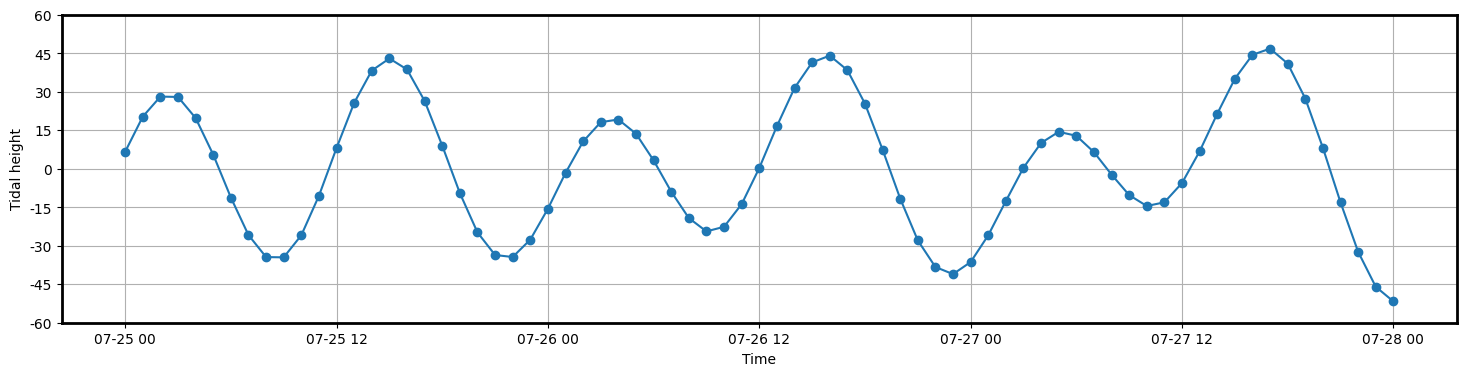

In [105]:
plot_tide(tide_level, dtime)

In [277]:
# Create current model object
def get_current_model(model_name, model_directory, model_format, compressed=False):
    return model(model_directory, format=model_format, compressed=compressed).current(model_name)

# Model parameters
tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5'

tpxo_curr_model = get_current_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)

In [124]:
print(tpxo_curr_model)
print(tpxo_curr_model.grid_file)
print(tpxo_curr_model.model_file)

/home/bioer/python/tide/data_src/TPXO9_atlas_v5/grid_tpxo9_atlas_30_v5.nc
{'u': [PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_q1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_o1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_p1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_n2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data

In [278]:
#read_netcdf_grid in ATLAS.py
#import netCDF4
fileID = netCDF4.Dataset(tpxo_curr_model.grid_file, 'r')
# read latitude and longitude at z-nodes
lonu = fileID.variables['lon_u'][:].copy()
latu = fileID.variables['lat_u'][:].copy()
print(lonu)
print(latu)
print(lonu.shape)
print(latu.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)
bathy_u = np.ma.zeros((ny,nx))
bathy_u.data[:,:] = fileID.variables['hu'][:,:].T
bathy_u.mask = (bathy_u.data == 0.0)

[1.66666675e-02 5.00000005e-02 8.33333334e-02 ... 3.59916663e+02
 3.59949996e+02 3.59983329e+02]
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
(10800,)
(5401,)
5401 10800


In [260]:
tolerance = 1e-9
def allIdentical(x, y, tolerance=1e-9):
    # Check if lon_u and lon_v are almost equal element-wise within the tolerance
    identicalx = np.allclose(x, y, atol=tolerance)

    if identicalx:
        print("The arrays are identical.")
        return None
    else:
        print("The arrays are not identical.")
        not_identical_mask = np.abs(x - y) > tolerance
        # Find the indices of elements that are not identical
        return np.where(not_identical_mask)

In [262]:
nlonidx = allIdentical(lonz, lonu)
nlatidx = allIdentical(latz, latu)
print(lonz[nlonidx])
print(lonu[nlonidx])

The arrays are not identical.
The arrays are identical.
[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[1.66666675e-02 5.00000005e-02 8.33333334e-02 ... 3.59916663e+02
 3.59949996e+02 3.59983329e+02]


In [279]:
fileID = netCDF4.Dataset(tpxo_curr_model.grid_file, 'r')
# read latitude and longitude at z-nodes
lonv = fileID.variables['lon_v'][:].copy()
latv = fileID.variables['lat_v'][:].copy()
print(lonv)
print(latv)
print(lonv.shape)
print(latv.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)
bathy_v = np.ma.zeros((ny,nx))
bathy_v.data[:,:] = fileID.variables['hv'][:,:].T
bathy_v.mask = (bathy_v.data == 0.0)

[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[-90.01667023 -89.98333689 -89.95000356 ...  89.91667022  89.95000356
  89.98333689]
(10800,)
(5401,)
5401 10800


In [263]:
nlonidx = allIdentical(lonu, lonv)
nlatidx = allIdentical(latu, latv)
print(lonu[nlonidx])
print(lonv[nlonidx])
print("--------------------")
print(latu[nlatidx])
print(latv[nlatidx])


The arrays are not identical.
The arrays are not identical.
[1.66666675e-02 5.00000005e-02 8.33333334e-02 ... 3.59916663e+02
 3.59949996e+02 3.59983329e+02]
[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
--------------------
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
[-90.01667023 -89.98333689 -89.95000356 ...  89.91667022  89.95000356
  89.98333689]


In [264]:
nlonidx = allIdentical(lonz, lonv)
nlatidx = allIdentical(latz, latv)
print(lonz[nlonidx])
print(lonv[nlonidx])
print("--------------------")
print(latz[nlatidx])
print(latv[nlatidx])

The arrays are identical.
The arrays are not identical.
[[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
  3.59966663e+02 3.59999996e+02]]
[[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
  3.59966663e+02 3.59999996e+02]]
--------------------
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
[-90.01667023 -89.98333689 -89.95000356 ...  89.91667022  89.95000356
  89.98333689]


In [316]:
# must rm -rf xx_chunks.zarr/
# check ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
# cp -R tpxo9_chunkz.zarr/ tpxo9_chunks.zarr
chunk_file = 'tpxo9_chunks.zarr'
chunku = tpxo2zarr(lonu, latu, bathy_u, 'u_amp', 'u_ph',  tpxo_curr_model, 45, grid_sz=1/30, 
                   chunk_file=chunk_file, type='u', mode="append_chunk", interpolate_to=(lonz, latz))
print(chunku)

0 10800 0 1351
model type is:  u
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
0 10800 1351 2702
model type is:  u
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
0 10800 2702 4053
model type is:  u
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
0 10800 4053 5401
model type is:  u
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
4


In [317]:
#chunk_file = 'tpxo9_chunks.zarr'
chunkv = tpxo2zarr(lonv, latv, bathy_v, 'v_amp', 'v_ph',  tpxo_curr_model, 45, grid_sz=1/30, 
                   chunk_file=chunk_file, type='v', mode="append_chunk", interpolate_to=(lonz, latz))
print(chunkv)

0 10800 0 1351
model type is:  v
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
0 10800 1351 2702
model type is:  v
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
0 10800 2702 4053
model type is:  v
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
0 10800 4053 5401
model type is:  v
['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
4


In [318]:
ds_combined = xr.concat([xr.open_zarr(chunk_file, group=f"chunk_{i}") for i in range(chunkv)], dim='lat')
chunk_size = 338
ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)


In [319]:
dz = xr.open_zarr('tpxo9.zarr', chunks='auto', decode_times=False)
print(dz)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon           (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    h_amp         (lat, lon, constituents) float64 dask.array<chunksize=(169, 1350, 2), meta=np.ndarray>
    h_ph          (lat, lon, constituents) float64 dask.array<chunksize=(169, 1350, 2), meta=np.ndarray>
    u_amp         (lat, lon, constituents) float64 dask.array<chunksize=(169, 1350, 2), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 dask.array<chunksize=(169, 1350, 2), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 dask.array<chunksize=(169, 1350, 2), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 dask.array<chunksize=(169, 1350, 2), meta=np.ndarray>


In [320]:
def get_current(dsel, tide_time, format='netcdf'):
    DELTAT = np.zeros_like(tide_time)
    c = dsel.coords['constituents'].values
    nx = dsel.coords['lon'].size
    ny = dsel.coords['lat'].size
    timelen = len(tide_time)
    tide = {}

    for TYPE in ['u', 'v']:
        amp = dsel[TYPE+'_amp'].values
        ph = dsel[TYPE+'_ph'].values
        shpx = amp.shape
        ampx = amp.reshape((shpx[0] * shpx[1], shpx[2]))
        phx = ph.reshape((shpx[0] * shpx[1], shpx[2]))
        # calculate complex phase in radians for Euler's
        cph = -1j * phx * np.pi / 180.0
        if TYPE=='v':
            print(ampx)
            print(phx)
            #print(np.imag(cph))
        # calculate constituent oscillation
        hc = ampx * np.exp(cph)
        # hc = (amp * np.exp(cph))[np.newaxis, :]
        # print(np.shape(hc))
        # Create a mask where values are NA or 0
        mask = np.isnan(hc) | (hc == 0)
        # Convert hc to a masked array
        hc = ma.array(hc, mask=mask) #mask=False

        tide[TYPE] = np.ma.zeros((ny, nx, timelen))

        for hour in range(timelen):
            # predict tidal elevations at time and infer minor corrections
            TIDE = map(tide_time[hour], hc, c, deltat=DELTAT[hour], corrections=format)
            MINOR = infer_minor(tide_time[hour], hc, c, deltat=DELTAT[hour], corrections=format)
            # add major and minor components and reform grid
            # Reshape TIDE and MINOR to have the shape (ny, nx)
            tide[TYPE][:,:,hour] = np.reshape((TIDE+MINOR),(ny,nx))
               
    return tide

In [334]:
x0, y0, x1, y1 = 118.0, 20.0, 129.75, 31.25 
#x0, y0, x1, y1 = 122.26672, 23.76175, 129.75, 31.25 #123.5, 28 #to test v is empty bug 
#x0, y0, x1, y1 = 123.75, 23.76175, 129.75, 31.25
grid_sz = 1/30
uvsub = dz.sel(lon=slice(x0-grid_sz, x1+grid_sz), lat=slice(y0-grid_sz, y1+grid_sz))
#print(uvsub['u_amp'].values)
#print(uvsub['u_ph'].values)


In [335]:
tide_curr = get_current(uvsub, tide_time[0:1])
print(tide_curr)

[[8.07763594e+02 4.51972062e+03 2.02236766e+03 ... 2.05491367e+02
  4.89114453e+01 2.29969849e+01]
 [8.09306289e+02 4.53152250e+03 2.02102281e+03 ... 2.06290371e+02
  4.65330176e+01 2.08616150e+01]
 [8.10744805e+02 4.54271750e+03 2.01939297e+03 ... 2.07146055e+02
  4.43613843e+01 1.88360474e+01]
 ...
 [1.44537808e+02 7.78356602e+02 2.77082109e+02 ... 1.09800469e+02
  1.99125687e+00 5.98874798e-01]
 [1.43174707e+02 7.68160977e+02 2.76981445e+02 ... 1.13186118e+02
  2.26126701e+00 6.67709808e-01]
 [1.42867939e+02 7.63390586e+02 2.79685566e+02 ... 1.18510537e+02
  2.60481056e+00 7.51914024e-01]]
[[247.88264285 255.55284283 295.68688755 ... 169.94445708 132.16376429
  115.99909709]
 [247.33764157 255.3871766  295.47733735 ... 169.87831353 128.21702827
  113.47613791]
 [246.78633943 255.23247623 295.26636305 ... 169.81969001 123.92416558
  110.6577184 ]
 ...
 [ 22.73873111  35.52432101  45.93628529 ... 259.57733031  81.61552524
   22.07042698]
 [ 19.7842124   32.76683192  43.05106995 ... 25

In [323]:
#print(uvsub['v_amp'].values)
print(uvsub['u_amp'].values)

[[[2.90073086e+02 1.43189531e+03 5.07786367e+02 ...            nan
              nan            nan]
  [3.06082686e+02 1.50537984e+03 5.37937793e+02 ...            nan
              nan            nan]
  [3.20774990e+02 1.57268391e+03 5.66797891e+02 ...            nan
              nan            nan]
  ...
  [5.87062559e+02 3.24217141e+03 1.22125777e+03 ... 1.49814502e+02
   5.20145752e+01 7.99230042e+00]
  [5.84270508e+02 3.22413844e+03 1.21554844e+03 ... 1.49493921e+02
   5.26910229e+01 8.47908356e+00]
  [5.81352969e+02 3.20547875e+03 1.20956191e+03 ... 1.49194106e+02
   5.34459106e+01 8.92961823e+00]]

 [[2.83694551e+02 1.39802750e+03 4.90304160e+02 ...            nan
              nan            nan]
  [2.99753633e+02 1.47319711e+03 5.19569570e+02 ...            nan
              nan            nan]
  [3.15464912e+02 1.54691602e+03 5.48846191e+02 ...            nan
              nan            nan]
  ...
  [5.86136250e+02 3.22890063e+03 1.21902453e+03 ... 1.49344570e+02
   5.40956

In [336]:
gtide = tide_curr
dsel = uvsub
# Set the time index (0 to 23)
t = 0
nx = dsel.coords['lon'].size
ny = dsel.coords['lat'].size
print(ny, nx)
glon, glat = np.meshgrid(dsel.coords['lon'].values, dsel.coords['lat'].values)

# Reshape u and v to 2D
u0 = gtide['u'][:,:,t] #.reshape(ny, nx)
v0 = gtide['v'][:,:,t] #.reshape(ny, nx)

# Create a grid of indices for subsetting
# ny, nx = np.shape(lon)
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

# Calculate magnitude of the current
magnitude = np.sqrt(u0**2 + v0**2)
print(magnitude)
print(u0)
print(v0)
# Normalize the arrows to create a uniform arrow size across the plot
u = u0/magnitude
v = v0/magnitude



n = 5
mask = (X % n == 0) & (Y % n == 0)

x = glon[mask]
y = glat[mask]
u = u[mask]
v = v[mask]
mag = magnitude[mask]*0.01

340 354
[[804.2725780141892 844.202062424625 884.3863877370522 ...
  2384.4827286351447 2393.662589465412 2403.5722636076184]
 [738.3742023076979 780.7523050924187 823.2041736472364 ...
  2388.7353425763504 2398.386357362013 2408.478650673607]
 [682.6488246727954 725.2172703232457 767.5109419579558 ...
  2391.1301729568236 2400.324770299412 2409.9159415250047]
 ...
 [-- -- -- ... 983.3183343743974 946.3616829861284 947.5611893052368]
 [-- -- -- ... 990.9077736358444 937.8211177429739 915.1819952172883]
 [-- -- -- ... 975.3954329828251 924.7553322233942 889.5656542816563]]
[[694.2342970148313 735.5644697573449 776.9460546556862 ...
  -2374.1862847491902 -2384.7744150269227 -2395.986510236583]
 [641.1010042635717 684.6973696616201 728.2129252831021 ...
  -2378.0116632566696 -2389.0932648640737 -2400.5100192765103]
 [598.5428637021819 641.7186130037468 684.5882778493082 ...
  -2379.9661115486037 -2390.607332249989 -2401.542876444835]
 ...
 [-- -- -- ... -956.3514195120413 -864.75962144142

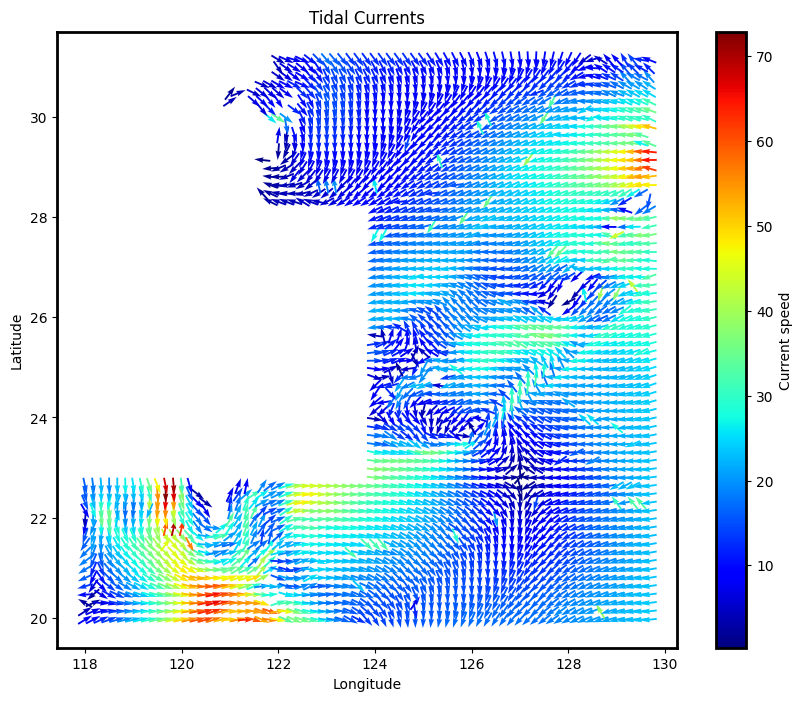

In [337]:
# Calculate magnitude of the current
# Create a figure and plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotting, note the "angles" and "scale" parameters
plt.colorbar(ax.quiver(x, y, u, v, mag, 
                       angles='xy', scale_units='xy', 
                       scale=3, pivot='middle', width=0.003, cmap='jet'), 
             ax=ax, label='Current speed')

ax.set_title('Tidal Currents')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


plt.show()

In [328]:
tmpx = np.linspace(uvsub.coords['lon'].values[0], uvsub.coords['lon'].values[-1], len(uvsub.coords['lon'].values) * 4)
print(uvsub.coords['lon'].values[1:4])
print(tmpx[1:16])
print(len(uvsub.coords['lon'].values))
print(len(tmpx))

[122.29999862 122.33333195 122.36666528]
[122.27497093 122.28327658 122.29158223 122.29988788 122.30819352
 122.31649917 122.32480482 122.33311047 122.34141612 122.34972176
 122.35802741 122.36633306 122.37463871 122.38294435 122.39125   ]
226
904


In [330]:
x0, y0, x1, y1 = 121.5, 22.5, 125.5, 29.5
grid_sz = 1/30
tsub = dz.sel(lon=slice(x0-grid_sz, x1+grid_sz), lat=slice(y0-grid_sz, y1+grid_sz))
print(tsub)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 212, lon: 122)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 22.47 22.5 22.53 22.57 ... 29.4 29.43 29.47 29.5
  * lon           (lon) float64 121.5 121.5 121.6 121.6 ... 125.5 125.5 125.5
Data variables:
    h_amp         (lat, lon, constituents) float64 dask.array<chunksize=(6, 122, 2), meta=np.ndarray>
    h_ph          (lat, lon, constituents) float64 dask.array<chunksize=(6, 122, 2), meta=np.ndarray>
    u_amp         (lat, lon, constituents) float64 dask.array<chunksize=(6, 122, 2), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 dask.array<chunksize=(6, 122, 2), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 dask.array<chunksize=(6, 122, 2), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 dask.array<chunksize=(6, 122, 2), meta=np.ndarray>


In [338]:
subset_lon_values = tsub.coords['lon'].values
subset_lat_values = tsub.coords['lat'].values

# Get the original lon and lat values
original_lon_values = dz.coords['lon'].values
original_lat_values = dz.coords['lat'].values

# Find the start and end indices of the subset lon and lat in the original lon and lat
start_lon = np.where(original_lon_values == subset_lon_values[0])[0][0]
end_lon = np.where(original_lon_values == subset_lon_values[-1])[0][0] + 1 # +1 for slice not include end

start_lat = np.where(original_lat_values == subset_lat_values[0])[0][0]
end_lat = np.where(original_lat_values == subset_lat_values[-1])[0][0] + 1
print(start_lon, end_lon, start_lat, end_lat)
#print(bathy_v[start_lat:end_lat, start_lon:end_lon])


3644 3766 3374 3586
(5401, 10800)
[[2589.258544921875 2923.62109375 3274.555419921875 ... 5433.6044921875
  5436.39306640625 5427.1884765625]
 [2451.84326171875 2821.434814453125 3206.4462890625 ... 5445.609375
  5449.431640625 5441.62451171875]
 [2220.51806640625 2620.22607421875 3047.17822265625 ... 5463.32373046875
  5466.4404296875 5459.8623046875]
 ...
 [-- 72.50139617919922 -- ... 90.44776916503906 90.90943908691406
  91.91969299316406]
 [76.15409851074219 73.03485870361328 71.8512954711914 ...
  89.89984130859375 90.33236694335938 91.33222961425781]
 [76.67552947998047 73.90521240234375 71.67303466796875 ...
  89.6236572265625 89.98246002197266 90.8456802368164]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [-- False -- ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
